In [4]:
import pandas as pd
df = pd.read_csv('/Users/yume/PycharmProjects/horizons_2/all_conversations_metrics_speaker1A.csv')

In [7]:
df

,convo_id,speaker_A,speaker_B,n_utterances,n_A,n_B,centroid_dist_mean,centroid_dist_std,centroid_dist_slope,cross_nn_A_to_B,...,mi_speaker_cluster,nmi_speaker_cluster,mi_turn_clusters,nmi_turn_clusters,entropy_slope_A,entropy_slope_B,align_eps,align_lag_A_to_B,align_lag_B_to_A,align_lag_asymmetry_AminusB
0,wired_time_12,"Brian Greene, PhD",Kayla Martini (Child),62,48,14,0.516158,0.121409,-0.005329,1.013389,...,0.083541,0.065415,1.210115,0.593479,0.037213,0.209504,1.252658,10.860465,3.142857,7.717608
1,wired_time_13,"Brian Greene, PhD",Maria Guseva (Teen),38,31,7,0.519293,0.158356,-0.010172,1.148145,...,0.199420,0.191846,0.808672,0.595497,0.057553,0.300914,1.247341,13.384615,1.857143,11.527473
2,wired_time_14,"Brian Greene, PhD",Zain Kamal (College Student),27,21,6,0.589380,0.170622,-0.019971,1.057109,...,0.071246,0.070719,0.643775,0.513489,0.055422,0.304485,1.209190,4.692308,1.200000,3.492308
3,wired_time_15,"Brian Greene, PhD",Alexander Novara (Grad Student),35,25,10,0.491062,0.183067,-0.014705,1.085377,...,0.117646,0.107367,0.270652,0.187066,0.067688,0.139212,1.230495,2.600000,2.500000,0.100000
4,wired_Talia_12,Speaker 1 (Talia Gershon),Speaker 2 (Child),11,6,5,0.820302,0.212480,-0.059571,1.068944,...,0.131041,0.151914,0.250201,0.250418,0.151912,0.355318,1.230598,2.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,wired_neuro_12,Speaker 1 (Dr. Bobby Kasthuri),Speaker 2 (Daniel Dodson),36,30,6,0.491093,0.169341,-0.011856,1.108628,...,0.073804,0.067419,0.549306,0.469279,0.046859,0.321113,1.215709,5.000000,3.500000,1.500000
60,wired_neuro_13,Speaker 1 (Dr. Bobby Kasthuri),Speaker 3 (Jabez Griggs),27,19,8,0.691213,0.176615,-0.020507,1.184190,...,0.176556,0.171420,0.000000,0.000000,0.076886,0.304910,1.258266,7.083333,5.714286,1.369048
61,wired_neuro_14,Speaker 1 (Dr. Bobby Kasthuri),Speaker 4 (Elena Dowling),35,23,12,0.553553,0.206690,-0.017620,1.070201,...,0.039674,0.034054,1.011404,0.721616,0.060154,0.231007,1.237001,6.600000,6.444444,0.155556
62,wired_neuro_15,Speaker 1 (Dr. Bobby Kasthuri),Speaker 5 (Mala Ananth),55,24,31,0.559679,0.226699,-0.012360,1.122042,...,0.145618,0.116876,0.995673,0.670786,0.083172,0.059500,1.276150,8.000000,9.961538,-1.961538


In [24]:
## reassigning labels
import re
EXPERTISE_ORDER = ["Child", "Teen", "College Student", "Graduate Student", "Expert"]
LABEL_TO_ORD = {lab: i for i, lab in enumerate(EXPERTISE_ORDER)}

SUFFIX_TO_EXPERTISE = {
    "12": "Child",
    "13": "Teen",
    "14": "College Student",
    "15": "Graduate Student",
    "16": "Expert",
}

EXPERTISE_PATTERNS = [
    (r"\bchild\b", "Child"),
    (r"\bteen(ager)?\b|\bhigh school\b|\byoung adult\b", "Teen"),
    (r"\bcollege\b|\bundergrad\b", "College Student"),
    (r"\bgrad(uate)?\b", "Graduate Student"),
    (r"\bexpert\b|\bphd\b|\bphysicist\b", "Expert"),
]

def infer_expertise_from_speaker_text(text):
    if pd.isna(text):
        return None
    s = str(text)

    # Prefer parentheses contents
    parens = re.findall(r"\(([^)]*)\)", s)
    for chunk in parens:
        chunk_l = chunk.lower()
        for pat, label in EXPERTISE_PATTERNS:
            if re.search(pat, chunk_l):
                return label

    # Fallback: scan whole string
    s_l = s.lower()
    for pat, label in EXPERTISE_PATTERNS:
        if re.search(pat, s_l):
            return label

    return None

def infer_expertise_from_convo_id(convo_id):
    if pd.isna(convo_id):
        return None
    m = re.search(r"_(\d{2})\b", str(convo_id))
    if not m:
        return None
    return SUFFIX_TO_EXPERTISE.get(m.group(1))

# infer from speaker strings
df["expertise_A"] = df["speaker_A"].apply(infer_expertise_from_speaker_text)
df["expertise_B"] = df["speaker_B"].apply(infer_expertise_from_speaker_text)

# fallback from convo_id suffix (especially useful for B)
mask_B_missing = df["expertise_B"].isna()
df.loc[mask_B_missing, "expertise_B"] = df.loc[mask_B_missing, "convo_id"].apply(infer_expertise_from_convo_id)

# in your "speaker1 as A" normalization, A is usually the explainer; if missing, assume Expert
mask_A_missing = df["expertise_A"].isna()
df.loc[mask_A_missing, "expertise_A"] = "Expert"

# ordinal + gaps
df["expertise_A_ord"] = df["expertise_A"].map(LABEL_TO_ORD)
df["expertise_B_ord"] = df["expertise_B"].map(LABEL_TO_ORD)

df["expertise_gap_signed"] = df["expertise_B_ord"] - df["expertise_A_ord"]
df["expertise_gap_abs"] = df["expertise_gap_signed"].abs()

print("Missing expertise_A:", df["expertise_A"].isna().sum())
print("Missing expertise_B:", df["expertise_B"].isna().sum())

df[["convo_id","speaker_A","expertise_A","speaker_B","expertise_B","expertise_A_ord","expertise_B_ord","expertise_gap_signed","expertise_gap_abs"]].head(10)


Missing expertise_A: 0
Missing expertise_B: 0


,convo_id,speaker_A,expertise_A,speaker_B,expertise_B,expertise_A_ord,expertise_B_ord,expertise_gap_signed,expertise_gap_abs
0,wired_time_12,"Brian Greene, PhD",Expert,Kayla Martini (Child),Child,4,0,-4,4
1,wired_time_13,"Brian Greene, PhD",Expert,Maria Guseva (Teen),Teen,4,1,-3,3
2,wired_time_14,"Brian Greene, PhD",Expert,Zain Kamal (College Student),College Student,4,2,-2,2
3,wired_time_15,"Brian Greene, PhD",Expert,Alexander Novara (Grad Student),Graduate Student,4,3,-1,1
4,wired_Talia_12,Speaker 1 (Talia Gershon),Expert,Speaker 2 (Child),Child,4,0,-4,4
5,wired_Talia_13,Speaker 1 (Talia Gershon),Expert,Speaker 3 (Teenager/Young Adult),Teen,4,1,-3,3
6,wired_Talia_14,Speaker 1 (Talia Gershon),Expert,Speaker 4 (Amanda - College Student),College Student,4,2,-2,2
7,wired_Talia_15,Speaker 1 (Talia Gershon),Expert,Speaker 5 (Grad Student),Graduate Student,4,3,-1,1
8,wired_Talia_16,Speaker 1 (Talia Gershon),Expert,Speaker 6 (Steve - Expert/Physicist),Expert,4,4,0,0
9,wired_gravity_12,Speaker 1 (Janna Levin),Expert,Speaker 2 (Bonét Sofía Kanayet),Child,4,0,-4,4


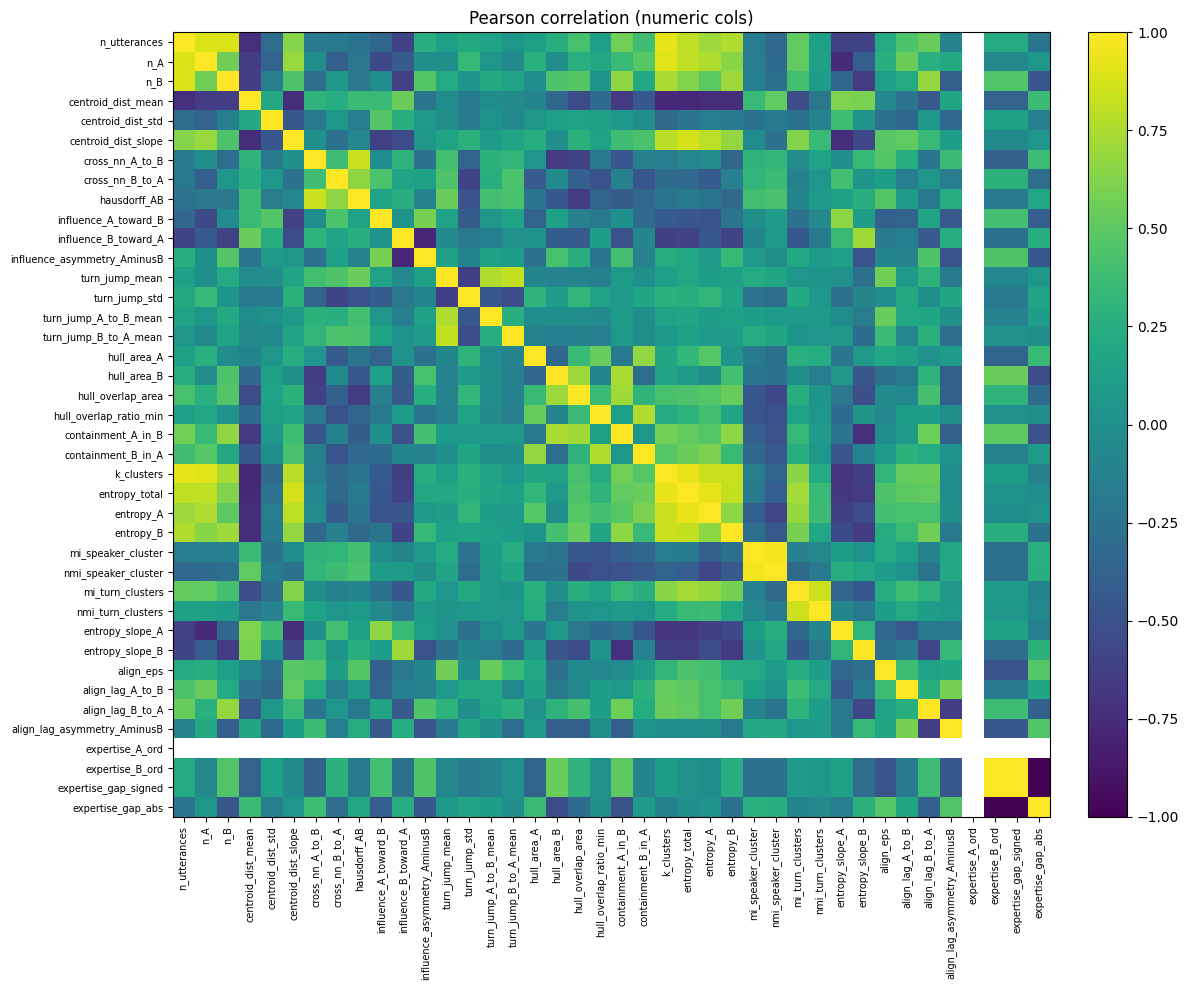

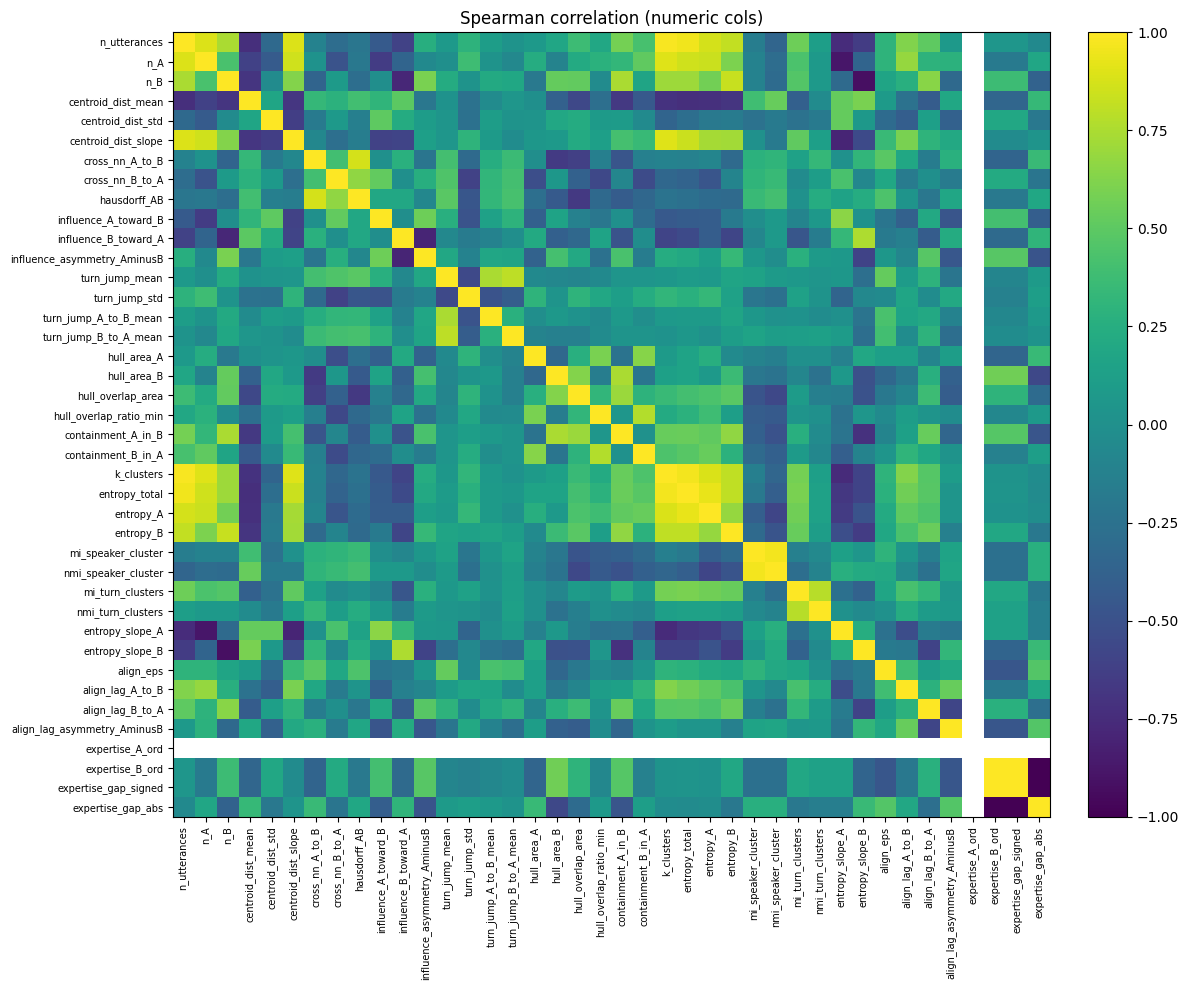

In [9]:
#corr plot
#choose numeric columns only
num_df = df.select_dtypes(include=[np.number]).copy()

# optionally drop obvious identifiers/derived if you want
# num_df = num_df.drop(columns=["expertise_A_ord"], errors="ignore")

pear = num_df.corr(method="pearson")
spear = num_df.corr(method="spearman")

def plot_corr(corr, title):
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(corr.values, aspect="auto")
    ax.set_title(title)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=90, fontsize=7)
    ax.set_yticklabels(corr.columns, fontsize=7)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

plot_corr(pear, "Pearson correlation (numeric cols)")
plot_corr(spear, "Spearman correlation (numeric cols)")


In [31]:
import re
import numpy as np

EXPERTISE_ORDER = ["Child", "Teen", "College Student", "Graduate Student", "Expert"]
LABEL_TO_ORD = {lab: i for i, lab in enumerate(EXPERTISE_ORDER)}

SUFFIX_TO_EXPERTISE = {
    "12": "Child",
    "13": "Teen",
    "14": "College Student",
    "15": "Graduate Student",
    "16": "Expert",
}

EXPERTISE_PATTERNS = [
    (r"\bchild\b", "Child"),
    (r"\bteen(ager)?\b|\bhigh school\b|\byoung adult\b", "Teen"),
    (r"\bcollege\b|\bundergrad\b", "College Student"),
    (r"\bgrad(uate)?\b", "Graduate Student"),
    (r"\bexpert\b|\bphd\b|\bphysicist\b", "Expert"),
]

def infer_expertise_from_speaker_text(text):
    if pd.isna(text):
        return None
    s = str(text)

    # check parentheses first
    parens = re.findall(r"\(([^)]*)\)", s)
    for chunk in parens:
        for pat, label in EXPERTISE_PATTERNS:
            if re.search(pat, chunk.lower()):
                return label

    # fallback: whole string
    for pat, label in EXPERTISE_PATTERNS:
        if re.search(pat, s.lower()):
            return label

    return None

def infer_expertise_from_convo_id(convo_id):
    if pd.isna(convo_id):
        return None
    m = re.search(r"_(\d{2})\b", str(convo_id))
    if not m:
        return None
    return SUFFIX_TO_EXPERTISE.get(m.group(1))

df_labeled = df.copy()

df_labeled["expertise_A"] = df_labeled["speaker_A"].apply(infer_expertise_from_speaker_text)
df_labeled["expertise_B"] = df_labeled["speaker_B"].apply(infer_expertise_from_speaker_text)






In [12]:
#one way anova

def eta_squared_oneway(feature, group_col="expertise_B"):
    d = df[[feature, group_col]].dropna()
    groups = [g[feature].values for _, g in d.groupby(group_col)]
    if len(groups) < 2:
        return np.nan

    y = d[feature].values
    grand_mean = np.mean(y)

    ss_between = 0.0
    for _, g in d.groupby(group_col):
        ss_between += len(g) * (g[feature].mean() - grand_mean) ** 2

    ss_total = np.sum((y - grand_mean) ** 2)
    return ss_between / ss_total if ss_total > 0 else np.nan

eta_rows = []
for col in num_df.columns:
    if col in ["expertise_A_ord", "expertise_B_ord", "expertise_gap_signed", "expertise_gap_abs"]:
        continue
    eta = eta_squared_oneway(col, "expertise_B")
    eta_rows.append((col, eta))

eta_df = pd.DataFrame(eta_rows, columns=["feature", "eta_sq"]).sort_values("eta_sq", ascending=False)
eta_df.head(20)


,feature,eta_sq
17,hull_area_B,0.365778
2,n_B,0.354889
20,containment_A_in_B,0.341686
11,influence_asymmetry_AminusB,0.309874
32,align_eps,0.250200
35,align_lag_asymmetry_AminusB,0.248544
34,align_lag_B_to_A,0.230564
9,influence_A_toward_B,0.228168
6,cross_nn_A_to_B,0.192415
16,hull_area_A,0.176739


Loaded: (64, 39)
Any duplicated columns left? False
Numeric-ish feature columns: 33


KeyError: "['expertise_B_ord'] not in index"

In [19]:
df

,convo_id,speaker_A,speaker_B,n_utterances,n_A,n_B,centroid_dist_mean,centroid_dist_std,centroid_dist_slope,cross_nn_A_to_B,...,mi_speaker_cluster,nmi_speaker_cluster,mi_turn_clusters,nmi_turn_clusters,entropy_slope_A,entropy_slope_B,align_eps,align_lag_A_to_B,align_lag_B_to_A,align_lag_asymmetry_AminusB
0,wired_time_12,"Brian Greene, PhD",Kayla Martini (Child),62,48,14,0.516158,0.121409,-0.005329,1.013389,...,0.083541,0.065415,1.210115,0.593479,0.037213,0.209504,1.252658,10.860465,3.142857,7.717608
1,wired_time_13,"Brian Greene, PhD",Maria Guseva (Teen),38,31,7,0.519293,0.158356,-0.010172,1.148145,...,0.199420,0.191846,0.808672,0.595497,0.057553,0.300914,1.247341,13.384615,1.857143,11.527473
2,wired_time_14,"Brian Greene, PhD",Zain Kamal (College Student),27,21,6,0.589380,0.170622,-0.019971,1.057109,...,0.071246,0.070719,0.643775,0.513489,0.055422,0.304485,1.209190,4.692308,1.200000,3.492308
3,wired_time_15,"Brian Greene, PhD",Alexander Novara (Grad Student),35,25,10,0.491062,0.183067,-0.014705,1.085377,...,0.117646,0.107367,0.270652,0.187066,0.067688,0.139212,1.230495,2.600000,2.500000,0.100000
4,wired_Talia_12,Speaker 1 (Talia Gershon),Speaker 2 (Child),11,6,5,0.820302,0.212480,-0.059571,1.068944,...,0.131041,0.151914,0.250201,0.250418,0.151912,0.355318,1.230598,2.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,wired_neuro_12,Speaker 1 (Dr. Bobby Kasthuri),Speaker 2 (Daniel Dodson),36,30,6,0.491093,0.169341,-0.011856,1.108628,...,0.073804,0.067419,0.549306,0.469279,0.046859,0.321113,1.215709,5.000000,3.500000,1.500000
60,wired_neuro_13,Speaker 1 (Dr. Bobby Kasthuri),Speaker 3 (Jabez Griggs),27,19,8,0.691213,0.176615,-0.020507,1.184190,...,0.176556,0.171420,0.000000,0.000000,0.076886,0.304910,1.258266,7.083333,5.714286,1.369048
61,wired_neuro_14,Speaker 1 (Dr. Bobby Kasthuri),Speaker 4 (Elena Dowling),35,23,12,0.553553,0.206690,-0.017620,1.070201,...,0.039674,0.034054,1.011404,0.721616,0.060154,0.231007,1.237001,6.600000,6.444444,0.155556
62,wired_neuro_15,Speaker 1 (Dr. Bobby Kasthuri),Speaker 5 (Mala Ananth),55,24,31,0.559679,0.226699,-0.012360,1.122042,...,0.145618,0.116876,0.995673,0.670786,0.083172,0.059500,1.276150,8.000000,9.961538,-1.961538


Index(['convo_id', 'speaker_A', 'speaker_B', 'n_utterances', 'n_A', 'n_B',
       'centroid_dist_mean', 'centroid_dist_std', 'centroid_dist_slope',
       'cross_nn_A_to_B', 'cross_nn_B_to_A', 'hausdorff_AB',
       'influence_A_toward_B', 'influence_B_toward_A',
       'influence_asymmetry_AminusB', 'turn_jump_mean', 'turn_jump_std',
       'turn_jump_A_to_B_mean', 'turn_jump_B_to_A_mean', 'hull_area_A',
       'hull_area_B', 'hull_overlap_area', 'hull_overlap_ratio_min',
       'containment_A_in_B', 'containment_B_in_A', 'k_clusters',
       'entropy_total', 'entropy_A', 'entropy_B', 'mi_speaker_cluster',
       'nmi_speaker_cluster', 'mi_turn_clusters', 'nmi_turn_clusters',
       'entropy_slope_A', 'entropy_slope_B', 'align_eps', 'align_lag_A_to_B',
       'align_lag_B_to_A', 'align_lag_asymmetry_AminusB'],
      dtype='object')

In [32]:
import re
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# =========================
# 1) EXPERTISE LABELING
# =========================

EXPERTISE_ORDER = ["Child", "Teen", "College Student", "Graduate Student", "Expert"]
LABEL_TO_ORD = {lab: i for i, lab in enumerate(EXPERTISE_ORDER)}

SUFFIX_TO_EXPERTISE = {
    "12": "Child",
    "13": "Teen",
    "14": "College Student",
    "15": "Graduate Student",
    "16": "Expert",
}

EXPERTISE_PATTERNS = [
    (r"\bchild\b", "Child"),
    (r"\bteen(ager)?\b|\bhigh school\b|\byoung adult\b", "Teen"),
    (r"\bcollege\b|\bundergrad\b", "College Student"),
    (r"\bgrad(uate)?\b", "Graduate Student"),
    (r"\bexpert\b|\bphd\b|\bphysicist\b", "Expert"),
]

def infer_expertise_from_speaker_text(text):
    if pd.isna(text):
        return None
    s = str(text)

    # Prefer parentheses content first
    parens = re.findall(r"\(([^)]*)\)", s)
    for chunk in parens:
        chunk_l = chunk.lower()
        for pat, label in EXPERTISE_PATTERNS:
            if re.search(pat, chunk_l):
                return label

    # Fallback: scan whole string
    s_l = s.lower()
    for pat, label in EXPERTISE_PATTERNS:
        if re.search(pat, s_l):
            return label
    return None

def infer_expertise_from_convo_id(convo_id):
    if pd.isna(convo_id):
        return None
    m = re.search(r"_(\d{2})\b", str(convo_id))
    if not m:
        return None
    return SUFFIX_TO_EXPERTISE.get(m.group(1))

def add_expertise_labels(df: pd.DataFrame, assume_speakerA_is_expert=False) -> pd.DataFrame:
    df = df.copy()

    if "speaker_A" not in df.columns or "speaker_B" not in df.columns:
        raise ValueError("Expected columns speaker_A and speaker_B in the CSV.")

    if "convo_id" not in df.columns:
        # still possible to label from speaker text only, but convo_id suffix fallback won't work
        df["convo_id"] = np.nan

    df["expertise_A"] = df["speaker_A"].apply(infer_expertise_from_speaker_text)
    df["expertise_B"] = df["speaker_B"].apply(infer_expertise_from_speaker_text)

    # fallback via convo_id suffix (very useful for Wired Explain sets)
    mask_B_missing = df["expertise_B"].isna()
    df.loc[mask_B_missing, "expertise_B"] = df.loc[mask_B_missing, "convo_id"].apply(infer_expertise_from_convo_id)

    if assume_speakerA_is_expert:
        mask_A_missing = df["expertise_A"].isna()
        df.loc[mask_A_missing, "expertise_A"] = "Expert"

    df["expertise_A_ord"] = df["expertise_A"].map(LABEL_TO_ORD)
    df["expertise_B_ord"] = df["expertise_B"].map(LABEL_TO_ORD)

    # signed gap: B - A (positive means B is "more expert" than A)
    df["expertise_gap_signed"] = df["expertise_B_ord"] - df["expertise_A_ord"]
    df["expertise_gap_abs"] = df["expertise_gap_signed"].abs()

    return df

# =========================
# 2) PARTIAL CORR (RESIDUAL)
# =========================

def _safe_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def partial_corr_residual(
    df: pd.DataFrame,
    x: str,
    y: str,
    controls: list[str],
    min_n: int = 8,
) -> tuple[float, int]:
    """
    Partial corr(x, y | controls) by residualizing x and y on controls, then correlating residuals.
    Returns (r, n). r is NaN if not computable.
    """
    cols = [x, y] + list(controls)
    cols = [c for c in cols if c in df.columns]

    if x not in cols or y not in cols:
        return np.nan, 0

    d = df[cols].copy()

    # coerce x and y to numeric; controls handled as numeric as well
    for c in cols:
        d[c] = _safe_numeric(d[c])

    d = d.dropna()
    if len(d) < min_n:
        return np.nan, len(d)

    # controls matrix
    X = d[controls].values if len(controls) > 0 else None

    # if no controls, just corr(x, y)
    if X is None or X.size == 0:
        xv = d[x].values
        yv = d[y].values
        if np.std(xv) == 0 or np.std(yv) == 0:
            return np.nan, len(d)
        return float(np.corrcoef(xv, yv)[0, 1]), len(d)

    # residualize x
    regx = LinearRegression().fit(X, d[x].values)
    rx = d[x].values - regx.predict(X)

    # residualize y
    regy = LinearRegression().fit(X, d[y].values)
    ry = d[y].values - regy.predict(X)

    if np.std(rx) == 0 or np.std(ry) == 0:
        return np.nan, len(d)

    r = float(np.corrcoef(rx, ry)[0, 1])
    return r, len(d)

# =========================
# 3) RUNNER: FEATURE LIST + REPORT
# =========================

DEFAULT_COUNT_COLS = ["n_utterances", "n_points", "n_A", "n_B"]
DEFAULT_ALIGNMENT_COLS = [
    # use whichever exist in your file
    "align_eps",
    "align_lag_A_to_B",
    "align_lag_B_to_A",
    "align_lag_asymmetry_AminusB",
    "influence_A_toward_B",
    "influence_B_toward_A",
    "influence_asymmetry_AminusB",
]

def get_numeric_feature_cols(df: pd.DataFrame, exclude: set[str]) -> list[str]:
    numeric_cols = []
    for c in df.columns:
        if c in exclude:
            continue
        # keep numeric-like cols; if object col but numeric strings, we'll handle later in coercion
        numeric_cols.append(c)
    return numeric_cols

def run_partial_corr_suite(
    df: pd.DataFrame,
    *,
    target_col: str,
    controls: list[str],
    exclude_cols: list[str] = None,
    min_n: int = 8,
    title: str = "",
) -> pd.DataFrame:
    """
    Partial corr(feature, target | controls) for all features.
    """
    exclude_cols = exclude_cols or []
    exclude = set(exclude_cols + [target_col] + controls)

    feature_cols = get_numeric_feature_cols(df, exclude=exclude)

    rows = []
    for feat in feature_cols:
        r, n = partial_corr_residual(df, x=feat, y=target_col, controls=controls, min_n=min_n)
        rows.append((feat, r, n))

    out = pd.DataFrame(rows, columns=["feature", "partial_r", "n"])
    out["abs_partial_r"] = out["partial_r"].abs()
    out = out.sort_values("abs_partial_r", ascending=False)

    if title:
        print(f"\n=== {title} ===")
        print(out.head(15).to_string(index=False))

    return out

# =========================
# 4) LOAD + LABEL + RUN BOTH FILES
# =========================

def analyze_file(
    path: str,
    *,
    assume_speakerA_is_expert: bool = False,
    min_n: int = 8,
    save_prefix: str = None,
):
    df = pd.read_csv(path)
    df_labeled = add_expertise_labels(df, assume_speakerA_is_expert=assume_speakerA_is_expert)

    # Choose controls you *actually* have
    controls_gap = []
    # recommended: control for counts + (optionally) alignment metrics if you want "beyond alignment"
    for c in DEFAULT_COUNT_COLS + DEFAULT_ALIGNMENT_COLS:
        if c in df_labeled.columns:
            controls_gap.append(c)

    # Partial corr: feature vs expertise_gap_abs
    pc_gap_abs = run_partial_corr_suite(
        df_labeled,
        target_col="expertise_gap_abs",
        controls=controls_gap,
        exclude_cols=["convo_id", "speaker_A", "speaker_B", "expertise_A", "expertise_B"],
        min_n=min_n,
        title=f"{path} | partial corr with expertise_gap_abs (controls={controls_gap})",
    )

    # Partial corr: feature vs expertise_gap_signed
    pc_gap_signed = run_partial_corr_suite(
        df_labeled,
        target_col="expertise_gap_signed",
        controls=controls_gap,
        exclude_cols=["convo_id", "speaker_A", "speaker_B", "expertise_A", "expertise_B"],
        min_n=min_n,
        title=f"{path} | partial corr with expertise_gap_signed (controls={controls_gap})",
    )

    # OPTIONAL: if you want "what predicts alignment, beyond gap?"
    # Example target: align_lag_asymmetry_AminusB (if present)
    pc_align = None
    align_target = "align_lag_asymmetry_AminusB"
    if align_target in df_labeled.columns:
        controls_align = [c for c in (DEFAULT_COUNT_COLS + ["expertise_gap_abs", "expertise_gap_signed"]) if c in df_labeled.columns]
        pc_align = run_partial_corr_suite(
            df_labeled,
            target_col=align_target,
            controls=controls_align,
            exclude_cols=["convo_id", "speaker_A", "speaker_B", "expertise_A", "expertise_B"],
            min_n=min_n,
            title=f"{path} | partial corr with {align_target} (controls={controls_align})",
        )

    if save_prefix:
        df_labeled.to_csv(f"{save_prefix}_labeled.csv", index=False)
        pc_gap_abs.to_csv(f"{save_prefix}_pc_gap_abs.csv", index=False)
        pc_gap_signed.to_csv(f"{save_prefix}_pc_gap_signed.csv", index=False)
        if pc_align is not None:
            pc_align.to_csv(f"{save_prefix}_pc_align.csv", index=False)

    return df_labeled, pc_gap_abs, pc_gap_signed, pc_align

# =========================
# 5) RUN THESE (EDIT PATHS)
# =========================

# Example paths — replace with your actual notebook paths:
SENT_PATH = "all_metrics.csv"
TRI_PATH  = "all_metrics_trigram.csv"

df_sent_labeled, sent_pc_abs, sent_pc_signed, sent_pc_align = analyze_file(
    SENT_PATH,
    assume_speakerA_is_expert=False,   # set True only if you want to force missing A labels -> Expert
    min_n=8,
    save_prefix="sentence",
)

df_tri_labeled, tri_pc_abs, tri_pc_signed, tri_pc_align = analyze_file(
    TRI_PATH,
    assume_speakerA_is_expert=False,
    min_n=8,
    save_prefix="trigram",
)

print("\nDone. Saved labeled + partial correlation tables if save_prefix was provided.")



=== all_metrics.csv | partial corr with expertise_gap_abs (controls=['n_utterances', 'n_A', 'n_B', 'align_eps', 'align_lag_A_to_B', 'align_lag_B_to_A', 'align_lag_asymmetry_AminusB', 'influence_A_toward_B', 'influence_B_toward_A', 'influence_asymmetry_AminusB']) ===
               feature  partial_r  n  abs_partial_r
  expertise_gap_signed  -1.000000 13       1.000000
        turn_jump_mean  -0.991239 13       0.991239
             entropy_A  -0.974463 13       0.974463
         entropy_total  -0.923663 13       0.923663
            k_clusters  -0.919207 13       0.919207
           hull_area_A   0.899078 13       0.899078
    containment_B_in_A   0.872843 13       0.872843
 turn_jump_A_to_B_mean  -0.857649 13       0.857649
hull_overlap_ratio_min   0.849887 13       0.849887
       expertise_B_ord  -0.848279 13       0.848279
 turn_jump_B_to_A_mean  -0.672240 13       0.672240
    containment_A_in_B  -0.650884 13       0.650884
         turn_jump_std  -0.622301 13       0.622301
    